In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls
# from ptycho_functions import RAAR_loop, mPIE_loop,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, plot_guess_and_model, get_circular_mask

Object pixel size: 2.1962328634132057e-08
Oversampling:  13.493654712810738


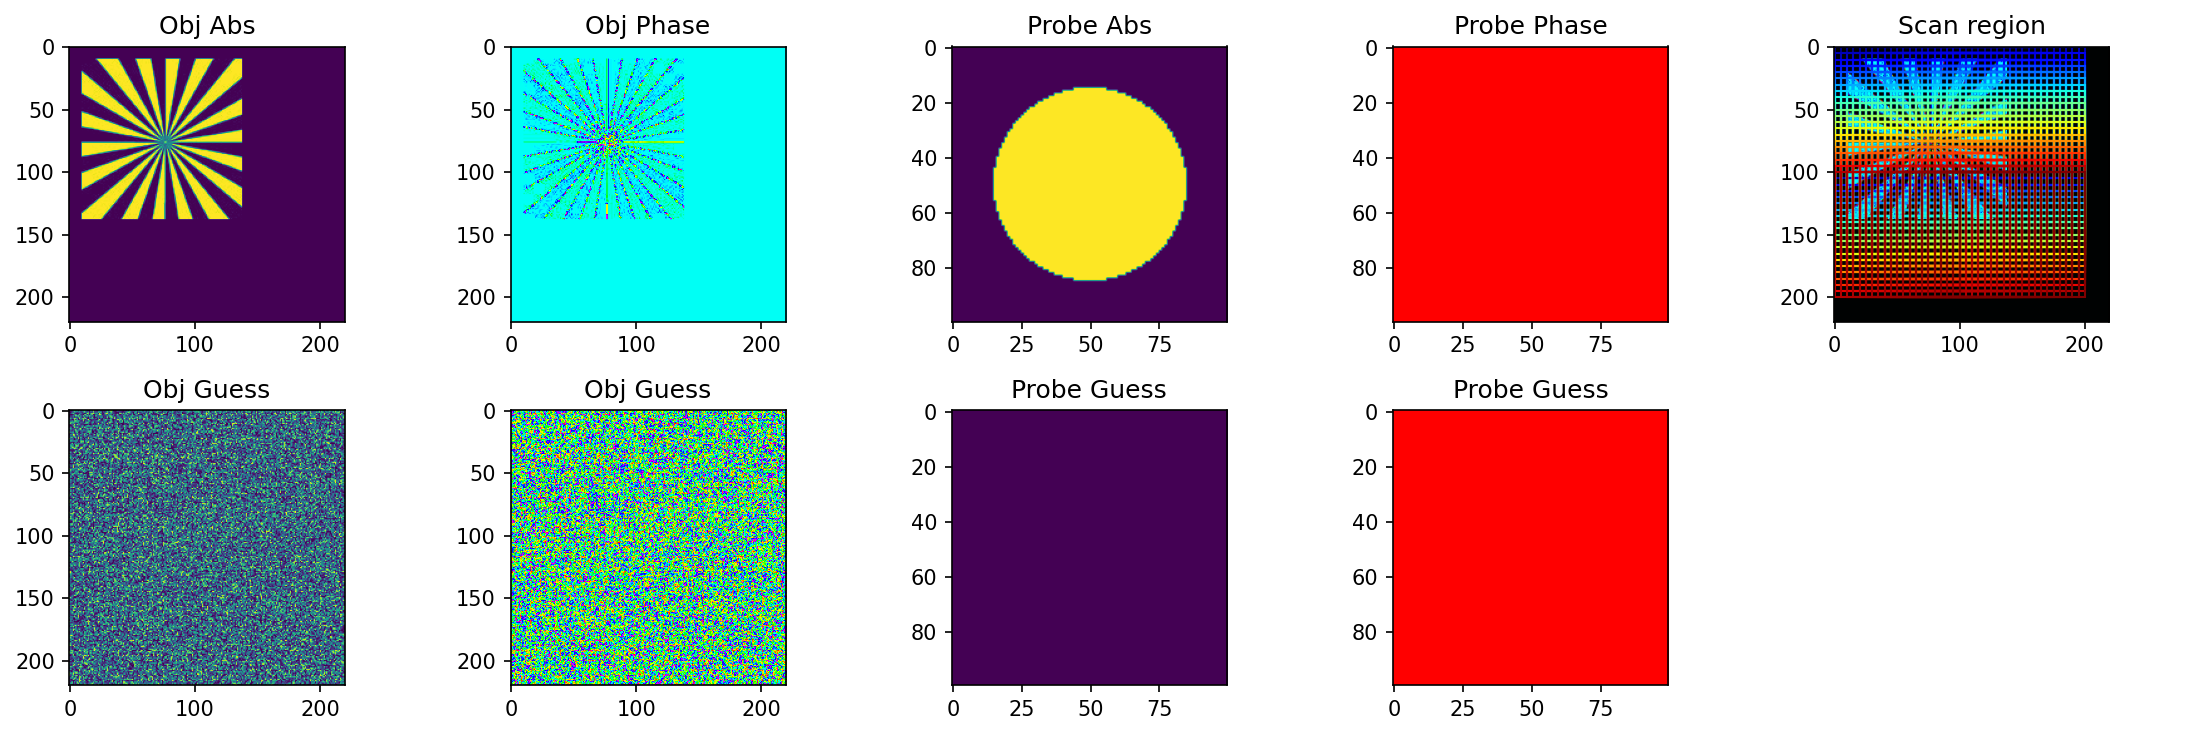

In [4]:
inputs = {
"path" : "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 120, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 6, #keV
"distance": 1, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [5,5], # pixels
"n_of_angles": 0
}

diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=False,add_position_errors=False,object_offset=10)

""" Experiment Parameters """
c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
oversampling_ratio = wavelength*distance/(position_step*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ",oversampling_ratio)
experiment_params = dx, wavelength,distance

probe_guess = model_probe*np.exp(-1j*model_probe*2)  
# probe_guess = get_circular_mask(model_probe.shape[0],0.3)
probe_guess = np.ones_like(probe_guess) 

obj_guess = np.ones_like(model_obj) # constant object
obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j


iterations = 100
n_of_modes = 1

# plot_positions_and_errors(data_folder,dataname,offset)
plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions)

Starting PIE...
	Iteration 0/100
	Iteration 25/100
	Iteration 50/100
	Iteration 75/100
Starting RAAR...
	Iteration 0/100
	Iteration 50/100
Starting multiprobe PIE algorithm...
	Iteration 0/100
	Iteration 50/100
PIE algorithm ended in 64.1979242269881 seconds


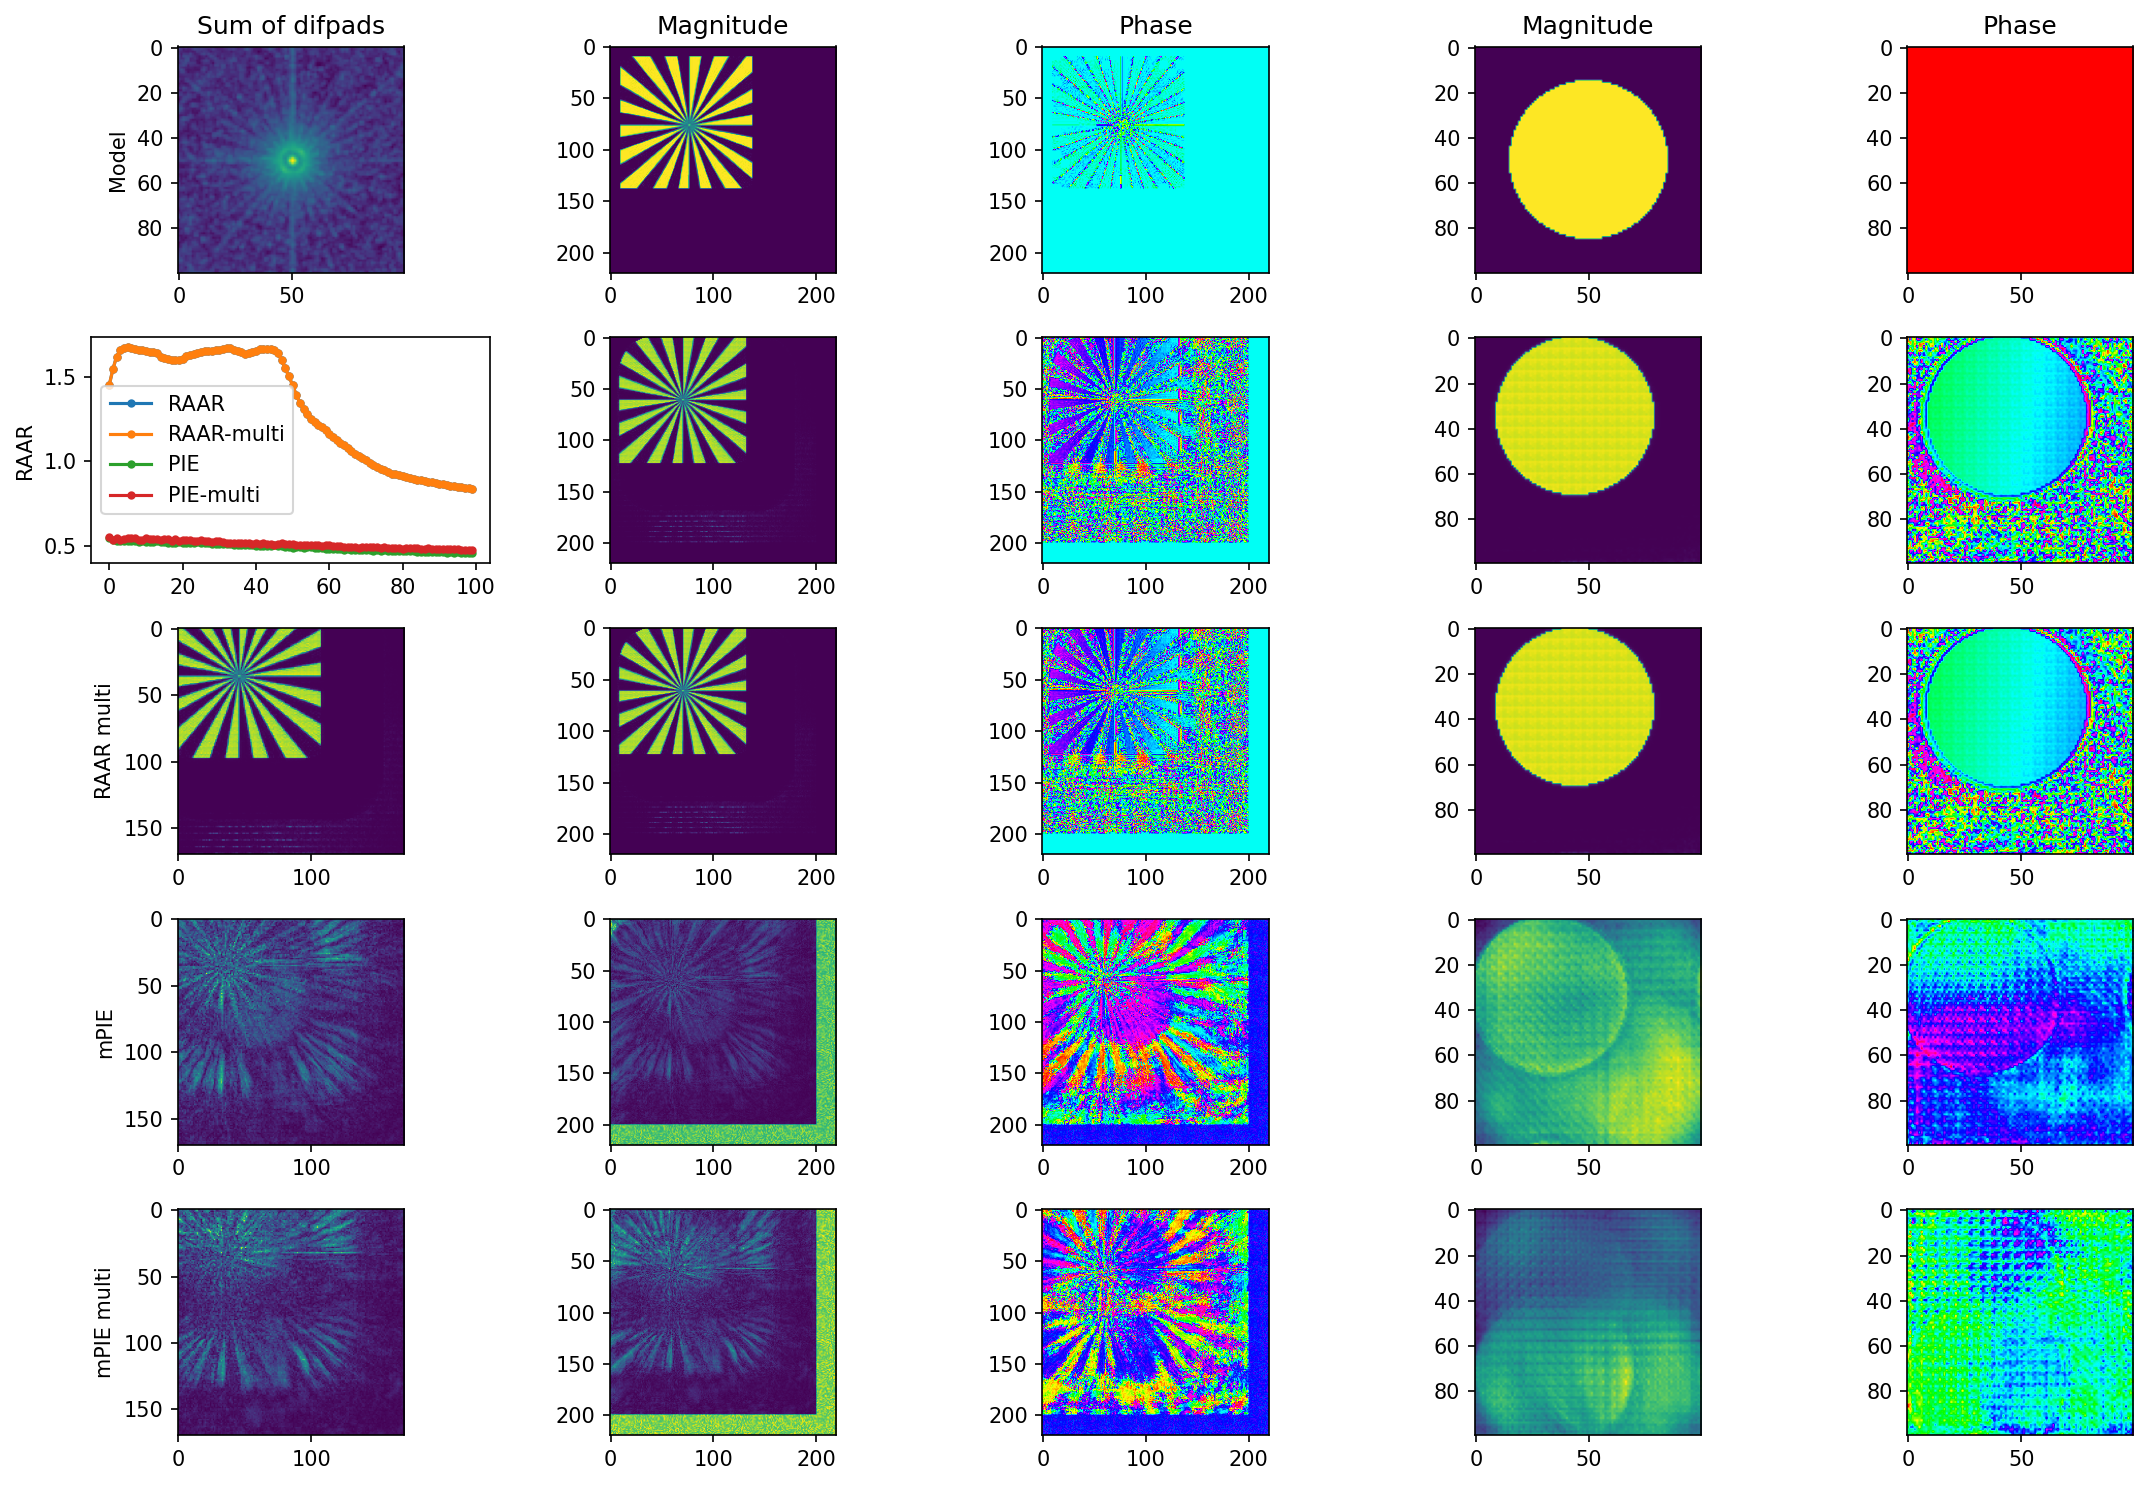

In [7]:
if 1:
    if 1: 
        """ mPIE """
        if 0: # suggested min from paper
            regularization_object, regularization_probe = 0.05, 0.5
            step_object, step_probe = 0.1, 0.2
            friction_object, friction_probe = 0.5, 0.75
            momentum_counter = 10
        elif 0: # suggested max from paper
            regularization_object, regularization_probe = 0.25, 5
            step_object, step_probe = 0.5, 1
            friction_object, friction_probe = 0.9, 0.99
            momentum_counter = 100 
        else: # my params
            regularization_object, regularization_probe = 0.25, 5
            step_object, step_probe = 0.5, 0.1
            friction_object, friction_probe = 0.9, 0
            momentum_counter = 100 

        centralize_probe = False
        mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
        PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time, positions_story = mPIE_loop(diffraction_patterns, positions.copy(),obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj,centralize_probe,beta=300)

    if 1: 
        """ RAAR """
        beta = 0.995
        epsilon = 0.01
        RAAR_params = (beta,epsilon)
        RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

    if 0:
        """ multiprobe RAAR """
        RAAR_params = (beta,epsilon)
        RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
        RAAR2_probe = RAAR2_probes[0]


    if 1:
        """ multiprobe mPIE """
        mPIE_params = {}
        mPIE_params["regularization_object"] = regularization_object
        mPIE_params["regularization_probe"]  = regularization_probe
        mPIE_params["step_object"]           = step_object
        mPIE_params["step_probe"]            = step_probe
        mPIE_params["friction_object"]       = friction_object
        mPIE_params["friction_probe"]        = friction_probe
        mPIE_params["momentum_counter"]      = momentum_counter
        PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
        PIE2_obj = PIE2_obj[0]
        PIE2_probe = PIE2_multiprobe[0]

        
    # RAAR_obj, RAAR_probe, RAAR_error, RAAR_time    =        PIE_obj, PIE_probe, PIE_error, PIE_time
    RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time  = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time   
    # PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = PIE_obj, PIE_probe, PIE_error, PIE_time

    plot_results3(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )

# plot_probe_modes(RAAR2_probes)
# plot_probe_modes(PIE2_multiprobe)

plt.show()


In [6]:
# plot_positions_and_errors(data_folder,dataname,offset,PIE_positions,positions_story)

NameError: name 'data_folder' is not defined